In [13]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from ndlinear import NdLinear
import matplotlib.pyplot as plt

In [14]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 614kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.98MB/s]


In [18]:
class CNNWithNdLinear(nn.Module):
    def __init__(self):
        super(CNNWithNdLinear, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # Output: (batch, 16, 28, 28)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) # Output: (batch, 32, 14, 14)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)                  # Reduces spatial dims by half
        self.relu = nn.ReLU()
        # NdLinear: input_dims=(32, 7, 7) matches (channels, height, width), hidden_size=(10, 1, 1) for 10 classes
        self.ndlinear = NdLinear(input_dims=(32, 7, 7), hidden_size=(10, 1, 1))

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # (batch, 16, 14, 14)
        x = self.pool(self.relu(self.conv2(x)))  # (batch, 32, 7, 7)
        x = self.ndlinear(x)                     # (batch, 10, 1, 1)
        x = x.view(-1, 10)                       # Flatten to (batch, 10) for classification
        return x

# Initialize model, loss, and optimizer
model = CNNWithNdLinear().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
class CNNWithLinear(nn.Module):
    def __init__(self):
        super(CNNWithLinear, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(32 * 7 * 7, 10)  # Flattened input

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)  # Flatten
        x = self.linear(x)
        return x

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNWithNdLinear().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.4316
Epoch [2/5], Loss: 0.2707
Epoch [3/5], Loss: 0.1919
Epoch [4/5], Loss: 0.0984
Epoch [5/5], Loss: 0.1701


In [20]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 95.01%


In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

ndlinear_model = CNNWithNdLinear()
linear_model = CNNWithLinear()
print(f'NdLinear Model Parameters: {count_parameters(ndlinear_model)}')
print(f'Linear Model Parameters: {count_parameters(linear_model)}')

NdLinear Model Parameters: 5146
Linear Model Parameters: 20490


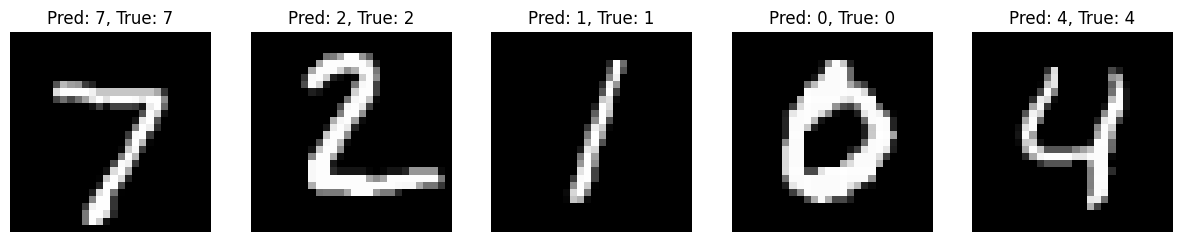

In [22]:
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(images[i].cpu().squeeze(), cmap='gray')
    axes[i].set_title(f'Pred: {predicted[i].item()}, True: {labels[i].item()}')
    axes[i].axis('off')
plt.show()